# Lab: Explainability in Neural Networks with activation maximitation.


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

------------------------------------------------------

In this part of the lab, we will implement a simple example of **activation maximization** to find out wich patterns are neccesary at the input of a neural network, that has been previously trained, to get a desired output (for example, a high confidence in a classification task).

We will visualize this technique using MNIST database.

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [32]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://i1.wp.com/datasmarts.net/es/wp-content/uploads/2019/09/1_yBdJCRwIJGoM7pwU-LNW6Q.png?w=479&ssl=1", width=400, height=200)

Load the dataset with torchvision ...

In [33]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.,), (1.0,)), # Media 0, varianza 1
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [34]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Let's show some image from that batch ...

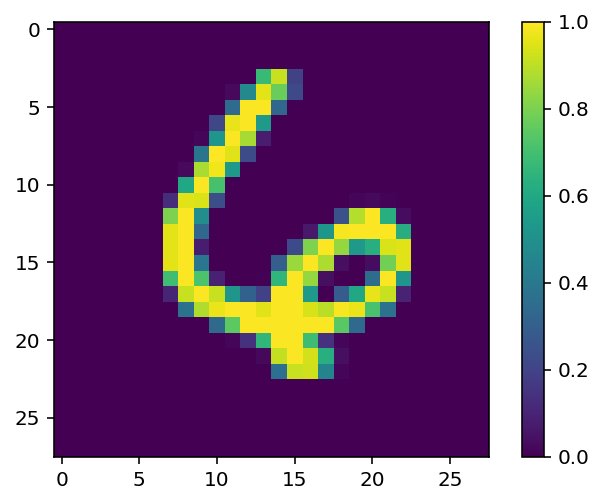

In [35]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='viridis')
plt.colorbar()

We also create a validation set.

In [36]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> **Exercise:** Train an MLP network based on four dense layers of 256, 128, 64 and 10 hidden units respectively. Calculate the accuracy in training and test sets after training only 3 epochs. If you notice overfitting problems, introduce whatever mechanisms you consider to reduce it.

In [37]:
class MLPdrop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)   
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)  
        x = self.dropout(x)     
        x = self.output2(x)
        x = self.relu(x)       
        x = self.output3(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

In [38]:
class MLPdrop_extended(MLPdrop):
    
    #Your code here
    
    def __init__(self,dimx,hidden1,hidden2,nlabels,prob,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,nlabels,prob)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # set model back to train mode
        self.train()
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    out = self.forward(images.view(images.shape[0], -1))

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            # set model back to train mode
            self.train()
                    
            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))

        self.eval()

We train and compute the accuracy ...

In [39]:
my_MLP_drop = MLPdrop_extended(dimx=784,hidden1=128,hidden2=64,nlabels=10,epochs=3,lr=1e-3,prob=0.)

my_MLP_drop.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.388359, Validation loss: 0.202107
Epoch 1. Training loss: 0.165083, Validation loss: 0.150593
Epoch 2. Training loss: 0.115183, Validation loss: 0.129125


In [40]:
from sklearn.metrics import accuracy_score

def accuracy(dataloader,model):

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        
        accuracy = 0.
            
        for images,labels in dataloader:
            
            logprobs = model.forward(images.view(images.shape[0], -1)).detach().numpy()
            
            prediction = np.argmax(logprobs,1)
            
            accuracy += accuracy_score(labels.numpy(),prediction,normalize=True)
        
        return accuracy/len(dataloader)

In [41]:
print(f"Train accuracy {accuracy(trainloader,my_MLP_drop)}")
print(f"Test accuracy {accuracy(testloader,my_MLP_drop)}")

Train accuracy 0.9758522727272727
Test accuracy 0.9650676751592356


We can see that the MNIST task is easy to solve. There are not overfitting problems.

## Activation Maximization

Once our network has been trained, the goal is to find which features at the input of the network (pixels in our case) are more important for the classifier to decide one class or another at the output. That is, choose between one digit or another at the output. 

The steps we follow are the following:

- We fix the parameters that we have just trained.

- We define a new set of trainable parameters that will emulate the input of the network and we will opbtimize to have a high confidence in a specific digit.

We implement the first step with the following code:

In [42]:
for param in my_MLP_drop.parameters(): #my_MLP_drop es el nombre de vuestra red!
    param.requires_grad = False

> **Exercise:** Complete the following code, in which we define the optimization problem to find the image at the input of the network that provides a given confidence in a given digit

In [43]:
class Optimize_NN_Input(nn.Module):

    def __init__(self,NN_trained,lr,img0): 
      
        # NN_trained is the trained network, as argument

        # img0 is a radomn initialization for the input image
        
        super().__init__()
        
        # Self.input --> Image to be optimized

        self.input = nn.Parameter(img0,requires_grad = True)

        self.NN_trained = NN_trained

        self.lr = lr
        
        # We use squared error to minimize the difference between the desired probability and the
        # obtained for self.input to input

        self.criterion = nn.MSELoss() 

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.loss_during_training = []

    def forward(self):

        # In the forward method we only evaluate the log-probabilities given self.input!

        #logprobs = self.NN_trained.forward(#YOUR CODE HERE)
        
        logprobs = self.NN_trained.forward(self.input) 

        return logprobs

    def trainloop(self,category,true_prob,sgd_iter):

        # Category is the digit we are going to look at

        # true_prob is the desired probability, which we pass to logarithm
        
        true_log_prob = torch.log(true_prob)

        # sgd_iter is the number of iterations
        
        for i in range(sgd_iter):

            # Reset the gradients
            #YOUR CODE HERE
            self.optim.zero_grad()  

            # Compute the current probabilities
            #YOUR CODE HERE
            logprobs = self.forward()
            
            # We calculate the difference between the desired probability (true_log_prob) and the obtained one
            # for the digit
            
            # loss = self.criterion(logprobs[0,#YOUR CODE HERE].view(true_log_prob.shape),#YOUR CODE HERE)
            loss = self.criterion(logprobs[0,category].view(true_log_prob.shape),true_log_prob)

            self.loss_during_training.append(loss)

            # Compute the gradients
            #YOUR CODE HERE
            loss.backward()
          
            #Optimize
            #YOUR CODE HERE
            self.optim.step()

Let's instanciate an object of the previous class for a random initialization (independent Gaussian distribution with mean zero and standard deviation 0.01)

In [44]:
opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(1,28**2)*0.01)

> **Exercise:** Obtain the probability distribution at the output of the classifier for the chosen initialization. Remember that the classifier uses a `logsoftmax` on output. Discuss the result.

Text(0, 0.5, 'Log-Probability')

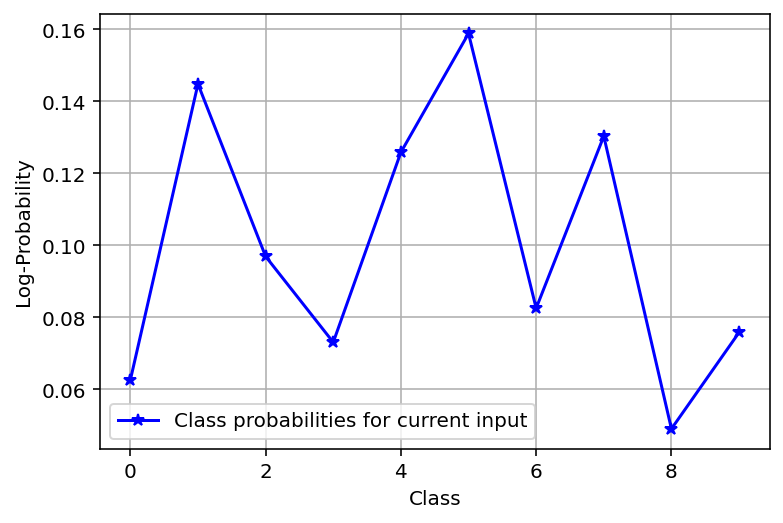

In [45]:
noisy_inputs_probs = np.exp(opt_input.forward().detach().numpy()).reshape(10,)

plt.plot(np.arange(0,10,1),noisy_inputs_probs,'-b*',label='Class probabilities for current input')
plt.grid()
plt.legend()
plt.xlabel('Class')
plt.ylabel('Log-Probability')

> **Exercise:**: Optimize the input representation for 50 iterations to obtain 90% confidence in the digit 3. Plot the loss function.

In [46]:
digito = 3

probabilidad = 0.9

opt_input.trainloop(digito,torch.Tensor([probabilidad]),50)

Text(0, 0.5, 'Loss function')

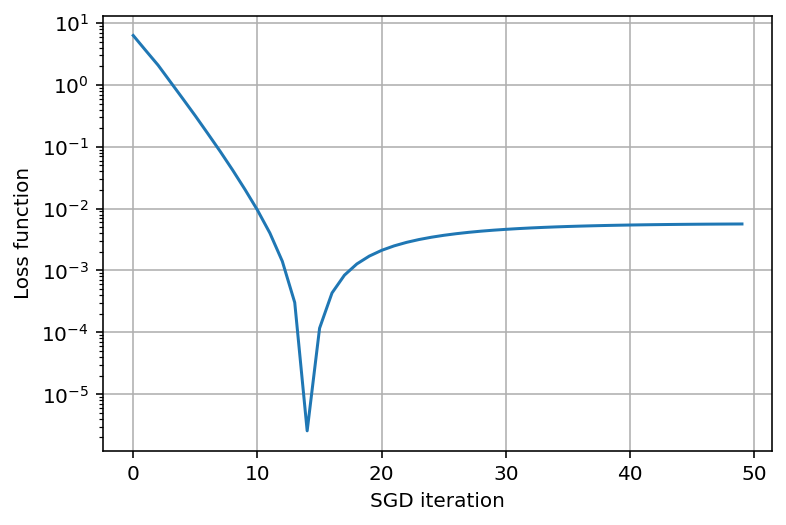

In [47]:
# Plot loss function

plt.semilogy(opt_input.loss_during_training)
plt.grid()
plt.xlabel('SGD iteration')
plt.ylabel('Loss function')

> **Ejercicio:** Compare the probabilities at the output of the classifier before and after optimizing at the input

Text(0, 0.5, 'Log-Probability')

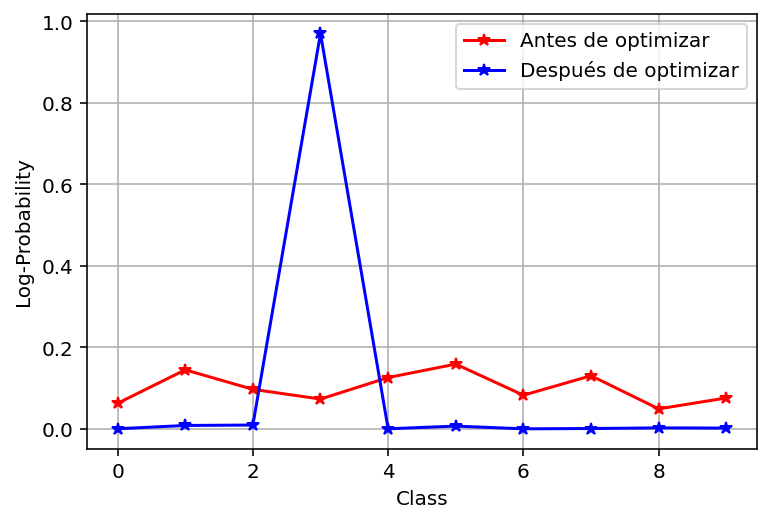

In [48]:
optimized_inputs_probs = np.exp(opt_input.forward().detach().numpy()).reshape(10,)

plt.plot(np.arange(0,10,1),noisy_inputs_probs,'-r*',label='Antes de optimizar')
plt.plot(np.arange(0,10,1),optimized_inputs_probs,'-b*',label='Después de optimizar')
plt.grid()
plt.legend()
plt.xlabel('Class')
plt.ylabel('Log-Probability')

> **Ejercicio:** Display the optimized input image. Does it roughly match the expected digit? Discuss the results.

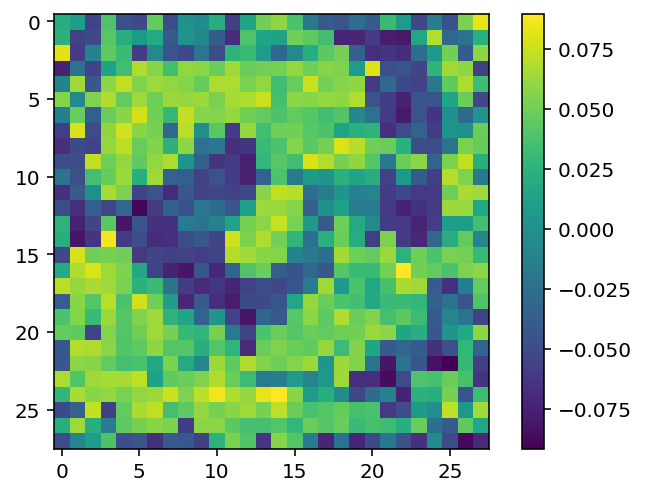

In [49]:
x = opt_input.input.detach().numpy()
plt.imshow(x.reshape([28,28]), cmap='viridis')
plt.colorbar()

The regions **with absolute value** (very negative/very positive) higher are those that have more relevance when classifying a digit as a 3. We can recognize the expected form.

> **Exercise:** Repeat the results for all digits and discuss them.

In [51]:
imagenes = []

for d in range(10):
    
    digito = d

    probabilidad = 0.9
    
    opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(1,28**2)*0.01)

    opt_input.trainloop(digito,torch.Tensor([probabilidad]),50)
    
    imagenes.append(opt_input.input.detach().numpy().reshape([28,28]))
                    

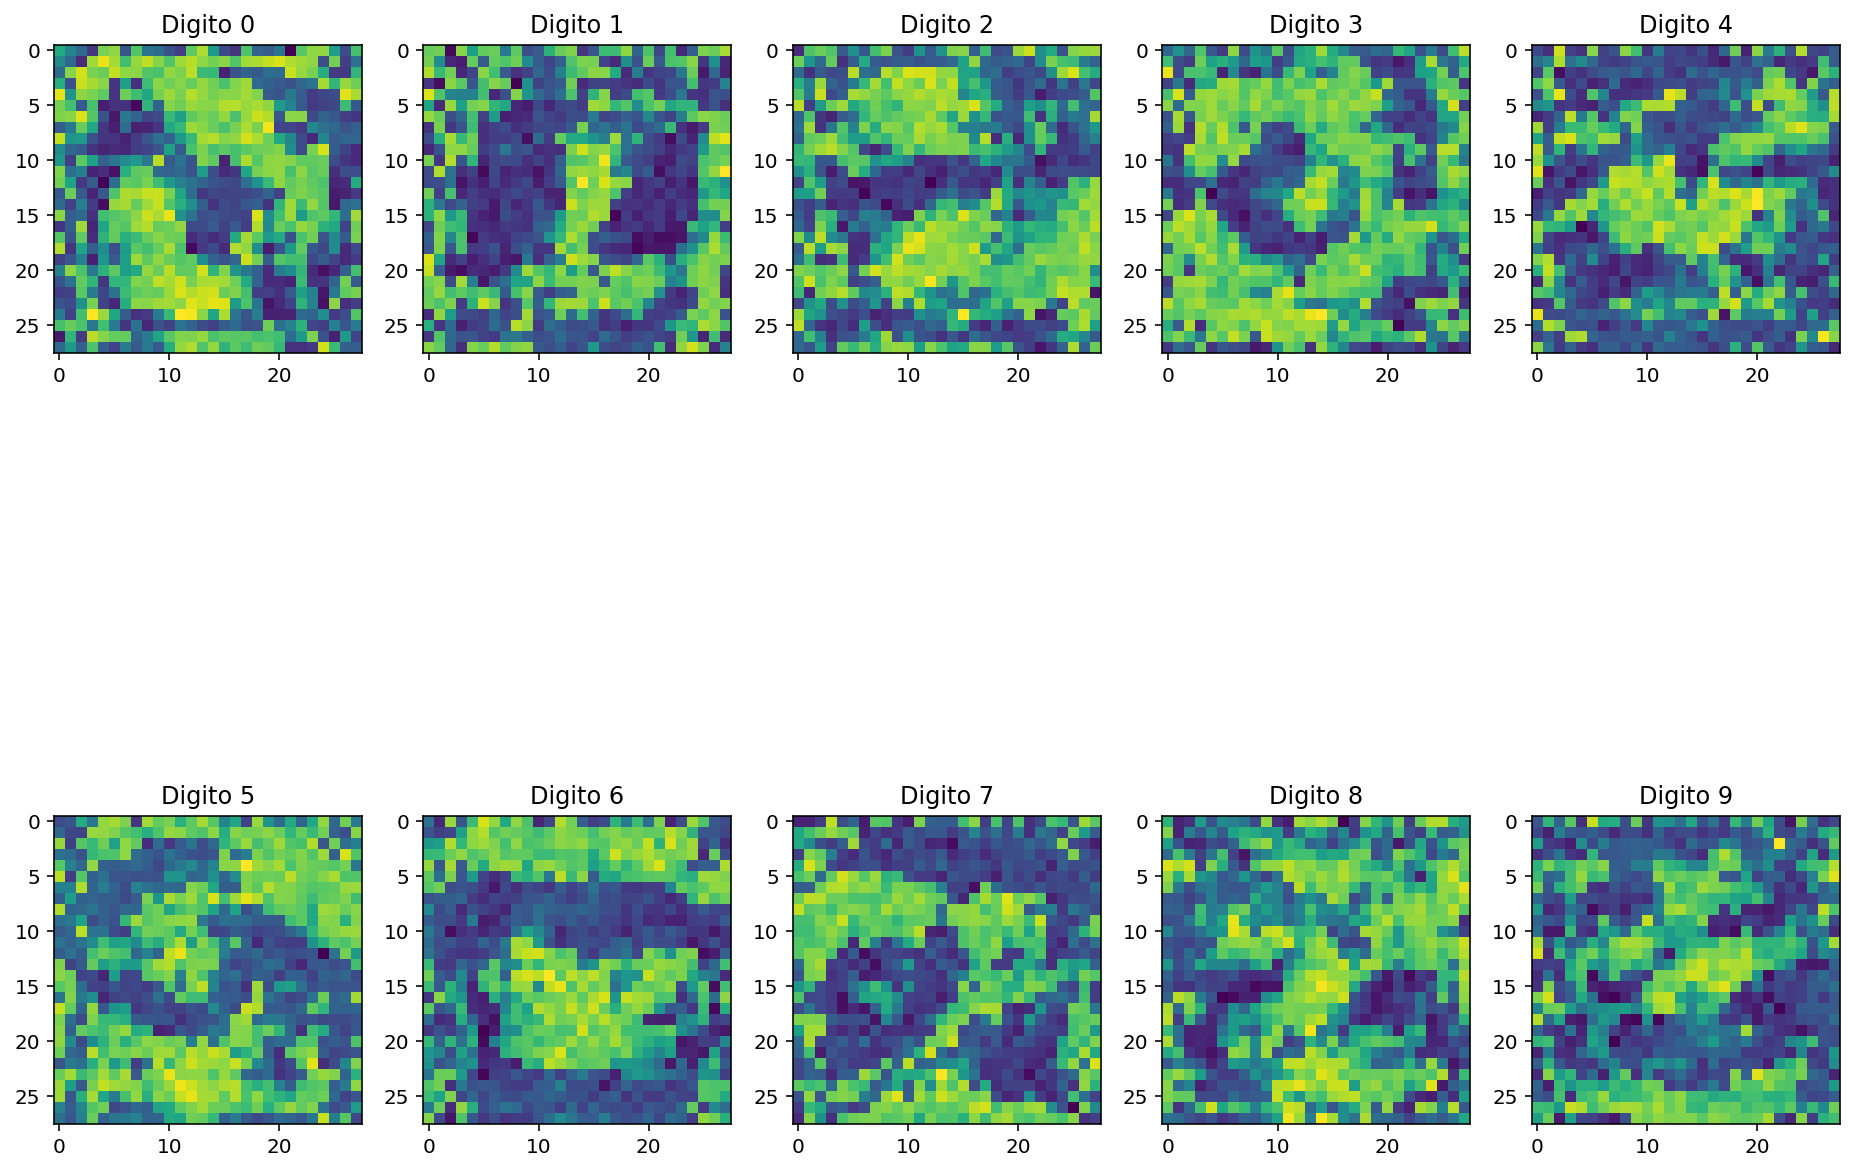

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 13))

for r in range(2):
    for c in range(5):
        
        ax[r,c].imshow(imagenes[r*5+c], cmap='viridis')
        ax[r,c].set_title(f'Digito {r*5+c}')

With other digits the image is not so clear. But keep in mind that
- The network does not have to use the whole region to classify the digit, it can only look at a small part
- We are implementing the network with MLPs, where each pixel is treated independently.

# Explainability at input using CNNs

Although with dense networks the performance of the classifier is very good, we are going to check how a CNN classifier manages to build the solution based on patterns in the most interpretable input images, since it takes into account the correlation between pixels.

> **Exercise:** Implement a classifier for MNIST based on the CNN LeNet-5 seen in one of the class examples. Note that when working with 32x32 images, the dimension of the maps at the output of the second CNN is not 5x5, as indicated in the figure, but 4x4.
>
> Train the classifier 3 epochs and get the accuracy in train and test sets.

In [53]:
Image(url= "https://ichi.pro/assets/images/max/724/0*H9_eGAtkQXJXtkoK")

In [54]:
class Lenet5(nn.Module):
    def __init__(self,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        
        # First convolutional layer: 3 input channels (RGB), 6 output. Filters 5x5, stride=1
        #and we don't use padding.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # Second convolutional layer: 6 input channels, 16 output channels and 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)
        
        self.final_dim = 16*4*4    # QUESTION: ¿Why 400?
    
        # Linear layer 
        self.linear1 = nn.Linear(self.final_dim,120)   
        
        self.linear2 = nn.Linear(120,84)
        
        self.linear3 = nn.Linear(84,10)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        

        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1, self.final_dim)
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x


In [55]:
import time

class Lenet5_extended(Lenet5):
    
    #Your code here
    
    def __init__(self,nlabels,epochs=100,lr=0.001):
        
        super().__init__(nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
    
        
    def trainloop(self,trainloader,validloader):
        
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  
            
                out = self.forward(images)

                
                loss = self.criterion(out,labels) # YOU CODE HERE

                running_loss += loss.item()

                #Compute the gradients
                loss.backward() # YOU CODE HERE
                
                #Paso de SGD 
                self.optim.step() # YOU CODE HERE
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validtion loss
            
            # Deactivate the gradients
            with torch.no_grad():
                
                self.eval()
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Batch output
                    out = self.forward(images) # YOU CODE HERE

                    #Loss function
                    loss = self.criterion(out,labels) # YOU CODE HERE

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                
                self.train()

            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))


In [56]:
my_CNN = Lenet5_extended(nlabels=10,epochs=3,lr=1e-3)

my_CNN.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.382205, Validation loss: 0.127849, Time per epoch: 15.231743 seconds
Epoch 1. Training loss: 0.094658, Validation loss: 0.080872, Time per epoch: 15.319686 seconds
Epoch 2. Training loss: 0.066909, Validation loss: 0.069009, Time per epoch: 15.593802 seconds


In [57]:
def accuracy_cnn(dataloader,model):

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        
        accuracy = 0.
            
        for images,labels in dataloader:
            
            logprobs = model.forward(images).detach().numpy()
            
            prediction = np.argmax(logprobs,1)
            
            accuracy += accuracy_score(labels.numpy(),prediction,normalize=True)
        
        return accuracy/len(dataloader)

In [58]:
print(f"Train accuracy {accuracy_cnn(trainloader,my_CNN )}")
print(f"Test accuracy {accuracy_cnn(testloader,my_CNN )}")

Train accuracy 0.9840864701704546
Test accuracy 0.9837778662420382


We see that by training the same number of epochs we have improved the accuracy by 2%

> **Exercise:** Using the function `Optimize_NN_Input`, perform the activation maximization analysis now for the trained CNN. Don't forget to disable gradients with respect to network parameters. Initialize the input image with the same independent Gaussian distribution with zero mean and standard deviation 0.01. Note that this input image now has dimensions [1,1,28,28] and optimize against the input image for at least 500 iterations (with CNNs optimization is slower).
>
> Visualize the input picture for each digit and discuss the results. 

In [59]:
for param in my_CNN.parameters(): #my_MLP_drop es el nombre de vuestra red!
    param.requires_grad = False

In [60]:
opt_input_2 = Optimize_NN_Input(NN_trained=my_CNN,lr=1e-3,img0=torch.randn(1,1,28,28)*0.01)

In [61]:
digito = 0

probabilidad = 0.9

opt_input_2.trainloop(digito,torch.Tensor([probabilidad]),int(500))

Text(0, 0.5, 'Loss function')

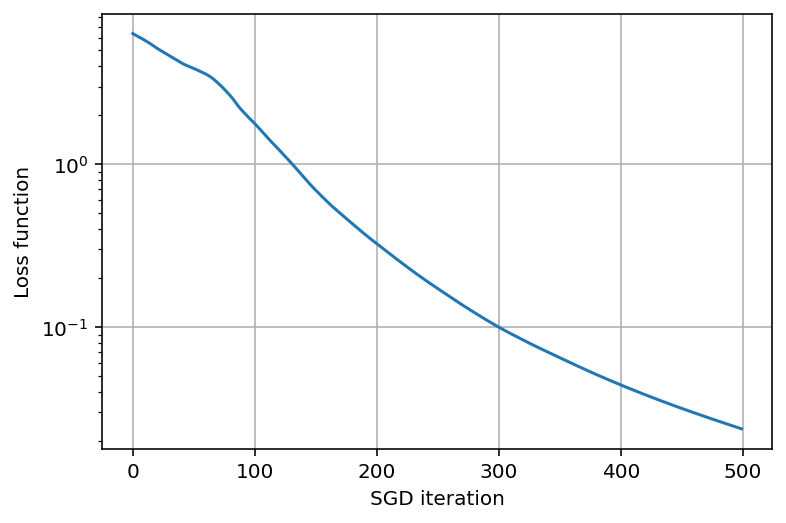

In [62]:
plt.semilogy(opt_input_2.loss_during_training)
plt.grid()
plt.xlabel('SGD iteration')
plt.ylabel('Loss function')

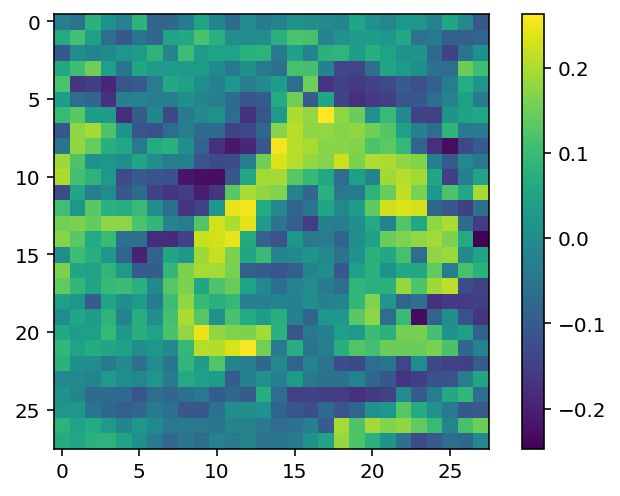

In [63]:
x = opt_input_2.input.detach().numpy().reshape([28,28])
plt.imshow(x.reshape([28,28]), cmap='viridis')
plt.colorbar()

In [64]:
imagenes = []

for d in range(10):
    
    digito = d

    probabilidad = 0.9
    
    opt_input = Optimize_NN_Input(NN_trained=my_CNN,lr=1e-3,img0=torch.randn(1,1,28,28)*0.01)

    opt_input.trainloop(digito,torch.Tensor([probabilidad]),int(500))
    
    imagenes.append(opt_input.input.detach().numpy().reshape([28,28]))
                    

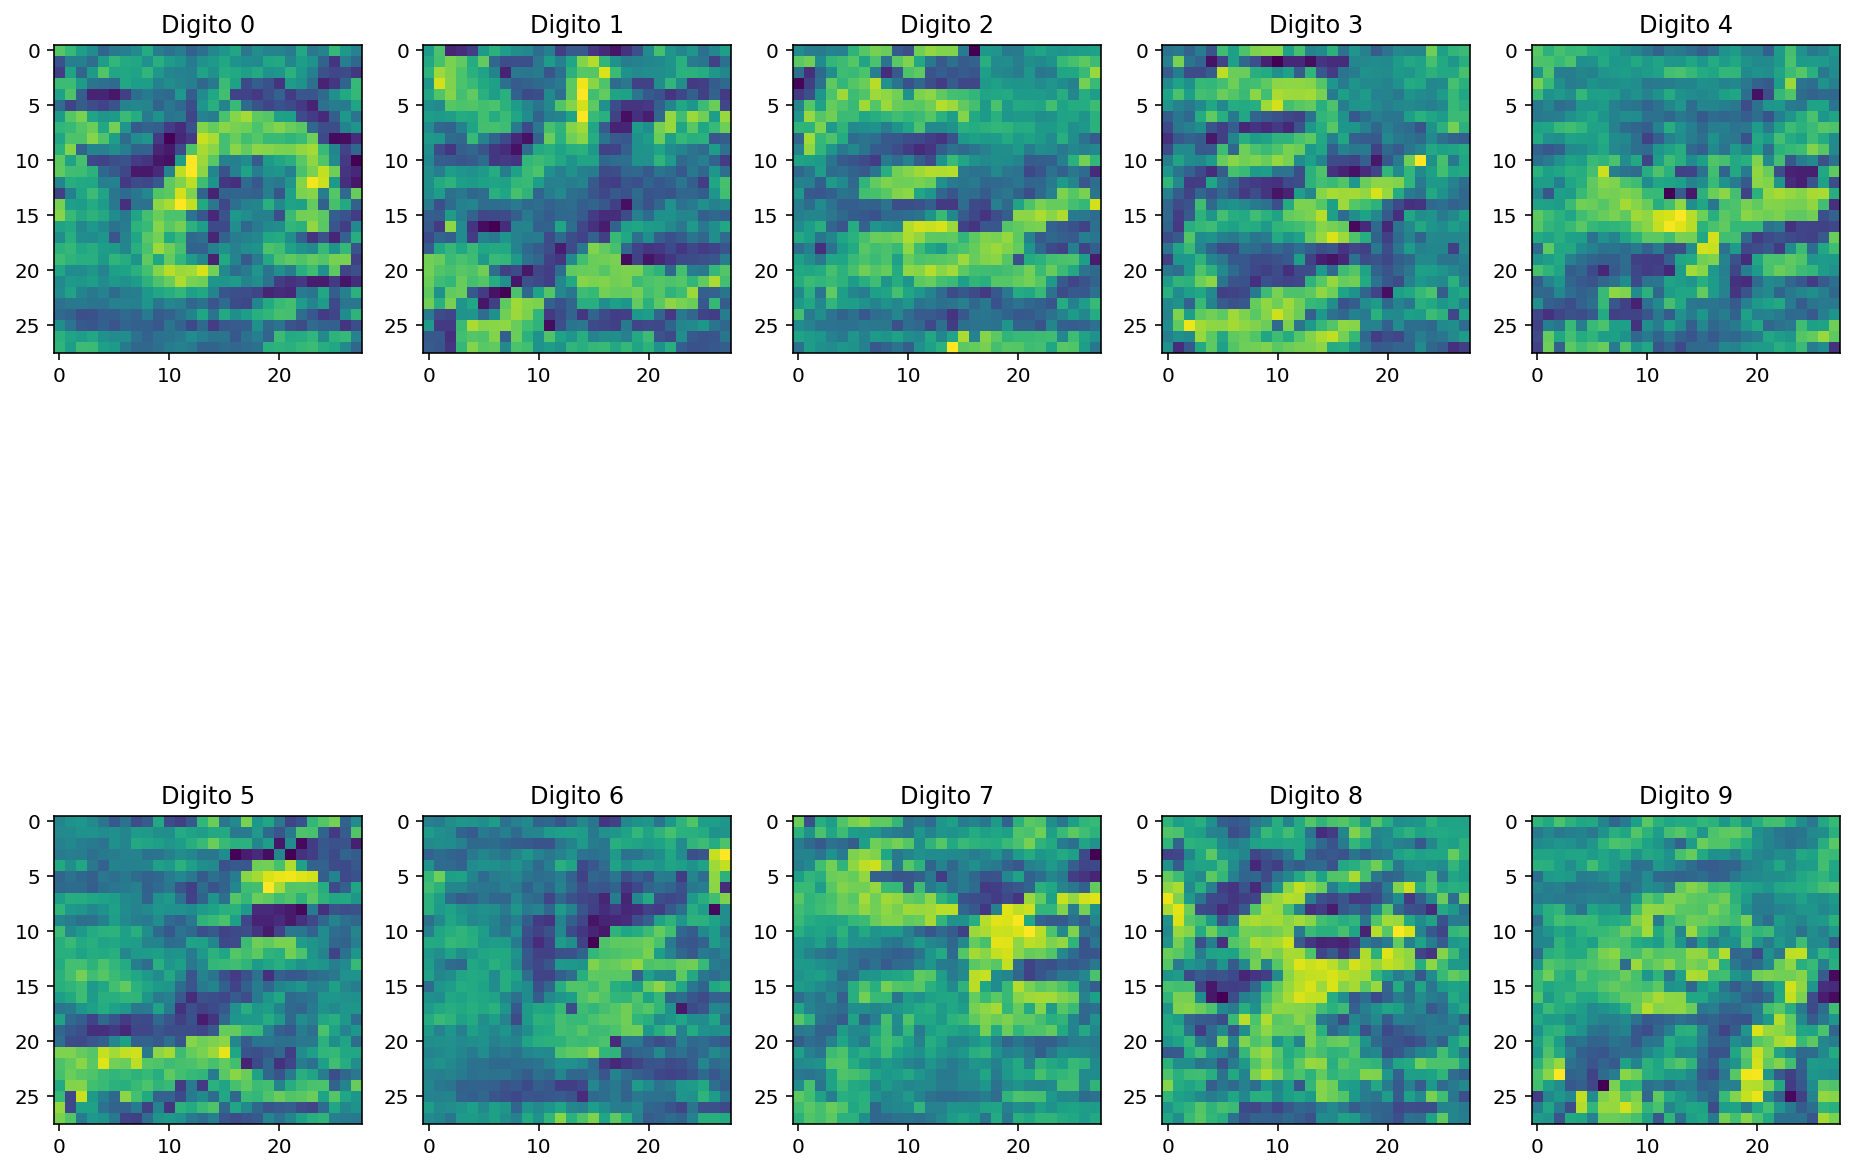

In [65]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 13))

for r in range(2):
    for c in range(5):
        
        ax[r,c].imshow(imagenes[r*5+c], cmap='viridis')
        ax[r,c].set_title(f'Digito {r*5+c}')